In [ ]:
from IPython.display import clear_output
# Install dew required libraries
!pip install pyunpack
!pip install patool
!pip install rasterio
clear_output()

In [ ]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import rasterio
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load files
path_tabular_data= "/content/drive/MyDrive/OpenGeoAIHack/tabular_data/"

df_train = gpd.read_file(f"{path_tabular_data}train.shp")
df_test = gpd.read_file(f"{path_tabular_data}test.shp")
samplesubmission = pd.read_csv(f"{path_tabular_data}SampleSubmission.csv")

# Preview train dataset
df_train.head()

,ID,target,geometry
0,i8KjaioEry,Oliver,"POLYGON ((594953.280 3941992.379, 595056.013 3..."
1,r4R40t2viH,Not_Oliver,"POLYGON ((590022.913 3938388.281, 590082.417 3..."
2,DO23GvlVNP,Oliver,"POLYGON ((590202.661 3938021.080, 590230.442 3..."
3,QREaKEZGg9,Not_Oliver,"POLYGON ((594379.858 3938850.027, 594367.825 3..."
4,S0I7TjiGk7,Oliver,"POLYGON ((592795.839 3936363.014, 592674.645 3..."


In [ ]:
# Preview test dataset
df_test.head()

,ID,geometry
0,mYiCy5N2Lu,"POLYGON ((587940.375 3943641.960, 588074.416 3..."
1,jj71Q5YNAP,"POLYGON ((595607.308 3944937.405, 595574.037 3..."
2,ULmJvrpODn,"POLYGON ((587491.810 3942159.830, 587482.838 3..."
3,h0kkdA6DZo,"POLYGON ((592256.633 3938431.801, 592325.964 3..."
4,1IdjR4SK5P,"POLYGON ((589721.780 3936337.519, 589751.318 3..."


In [ ]:
# Preview sample submission file
samplesubmission.head()

,ID,target
0,mYiCy5N2Lu,NaN
1,jj71Q5YNAP,NaN
2,ULmJvrpODn,NaN
3,h0kkdA6DZo,NaN
4,1IdjR4SK5P,NaN


In [ ]:
# Check size and shape of datasets
df_train.shape, df_test.shape, samplesubmission.shape

((1015, 3), (501, 2), (501, 2))

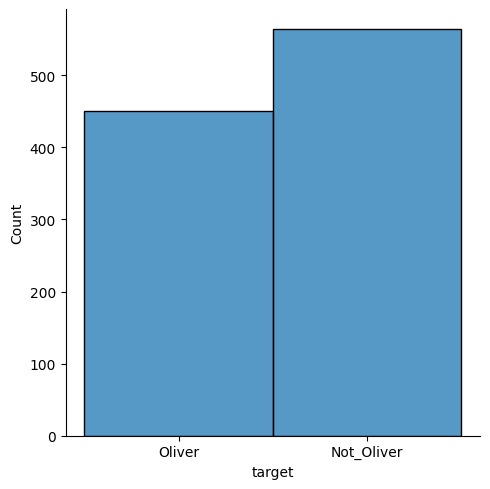

In [ ]:
sns.displot(df_train, x="target")

In [ ]:
# Extract the data in a drive folder if necessary
from pyunpack import Archive
Archive('/content/drive/MyDrive/OpenGeoAIHack/satellite_data/data_sentinel2_2A.zip').extractall('/content/drive/MyDrive/OpenGeoAIHack/satellite_data/')

In [ ]:
# Load the images paths
path_satellite__data= "/content/drive/MyDrive/OpenGeoAIHack/satellite_data/GeoAIHack2023/"
images_list= os.listdir(path_satellite__data)

In [ ]:
images_list

['20210217.tif',
 '20210329.tif',
 '20201231.tif',
 '20210209.tif',
 '20201214.tif',
 '20210115.tif',
 '20210219.tif',
 '20210212.tif',
 '20210311.tif',
 '20201229.tif',
 '20210120.tif',
 '20201114.tif',
 '20210130.tif',
 '20210428.tif',
 '20201109.tif',
 '20210425.tif',
 '20210113.tif',
 '20201126.tif',
 '20201224.tif',
 '20210108.tif',
 '20210306.tif',
 '20201216.tif',
 '20210123.tif',
 '20210227.tif']

In [ ]:
# Open 1 timestamp example image
image_path = f"{path_satellite__data}{images_list[0]}"
with rasterio.open(image_path) as src:
    # Get the image metadata
    metadata = src.meta
    # Read the image as an array
    image = src.read()

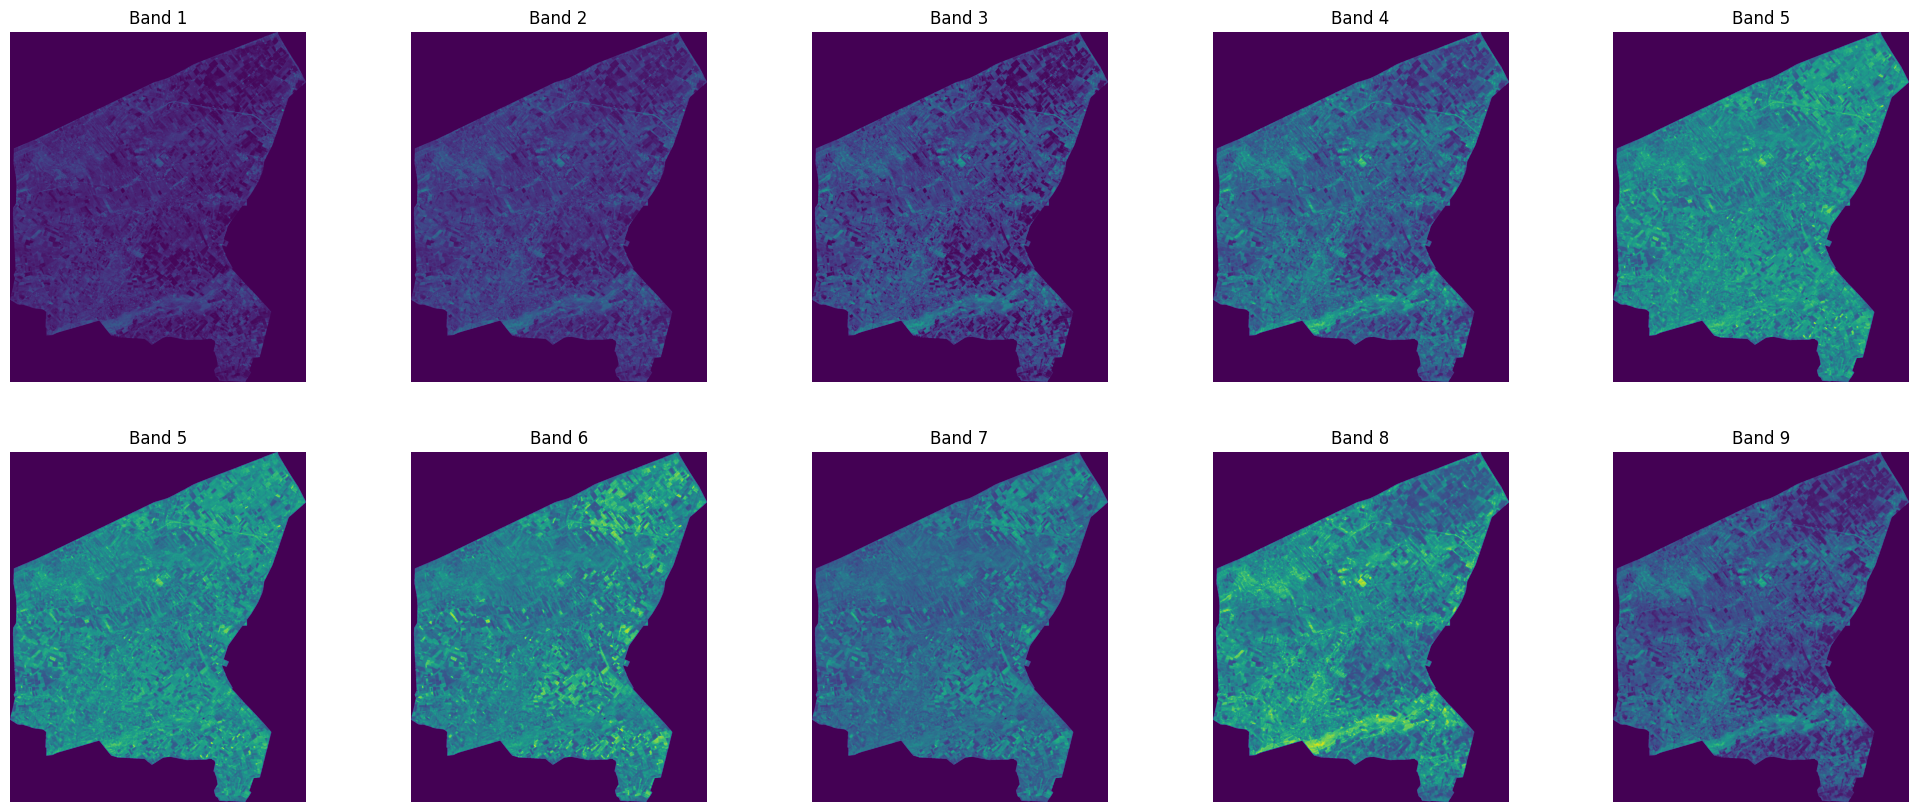

In [ ]:
# Plot the Spectral-Bands of the image
# The Sentinel-2 Spectral band includes "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"
fig, ax = plt.subplots(2, 5, figsize=(25, 10))

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(image[i*4+j,:,:])
        ax[i,j].set_title("Band {}".format(i*4+j+1))
        ax[i,j].axis("off")

In [ ]:
# Extract filed images into a numpy array with shape (number_of_fields, 10, 16, 16)
from rasterio.features import geometry_mask

# Initialize empty lists to store the field images and bounding boxes
train_fileds_images=[]
train_bboxes= []
# Loop through each field in the training dataset
for index, row in df_train.iterrows():
    # Get the geometry of the field
    field_geometry = row['geometry']
    # Create a mask for the field
    field_mask = geometry_mask([field_geometry], out_shape=src.shape, transform=src.transform, invert=True)

    # Get the bounding box of the field
    True_mask= np.where(field_mask==True)
    x_min=True_mask[0].min()
    x_max=True_mask[0].max()
    y_min=True_mask[1].min()
    y_max=True_mask[1].max()
    train_bboxes.append([x_min, y_min, x_max, y_max])

    # Extract the image data for the field and resize it
    field_image = image[:, x_min:x_max, y_min:y_max]
    resized_field_image=[]
    for channel in range(10):
      # Resize the image using OpenCV
      resized_field_channel = cv2.resize(field_image[channel], (16, 16), interpolation=cv2.INTER_LINEAR)
      resized_field_image.append(resized_field_channel)
    resized_field_image= np.array(resized_field_image)
    train_fileds_images.append(resized_field_image)

# Convert the lists to numpy arrays
train_fileds_images= np.array(train_fileds_images)
print(train_fileds_images.shape)

(1015, 10, 16, 16)


ml approach

In [ ]:
# Transform the field image data into statistical features (mean and std of each spectral Bands) and combine them into a dataframe

# Concatenate the training and testing dataframes into a single dataframe
df_all= pd.concat([df_train, df_test], ignore_index=True)

# Initialize an empty list to store the processed data
processed_data= []
# Loop through each field in the concatenated dataframe
for index, row in df_all.iterrows():
    # Get the geometry of the field
    field_geometry = row['geometry']
    # Create a mask for the field
    field_mask = geometry_mask([field_geometry], out_shape=src.shape, transform=src.transform, invert=True)
    # Extract the image data for the field
    field_data = image[:, field_mask]

    # Compute the mean and standard deviation of each channel of the image data
    mean_values = np.mean(field_data, axis=1)
    std_values = np.std(field_data, axis=1)

    # Concatenate the mean and standard deviation values into a single feature vector
    features = np.concatenate([mean_values, std_values])
    # Append the feature vector to the list of processed data
    processed_data.append(features)

# Convert the list of processed data into a pandas dataframe
processed_data_df= pd.DataFrame(processed_data, columns=[f"mean_channel_{i}" for i in range(0, 10)] + [f"std_channel_{i}" for i in range(0, 10)])
processed_data_df["ID"]= df_all["ID"]

In [ ]:
processed_data_df.head()

,mean_channel_0,mean_channel_1,mean_channel_2,mean_channel_3,mean_channel_4,mean_channel_5,mean_channel_6,mean_channel_7,mean_channel_8,mean_channel_9,...,std_channel_1,std_channel_2,std_channel_3,std_channel_4,std_channel_5,std_channel_6,std_channel_7,std_channel_8,std_channel_9,ID
0,806.856683,1243.581320,1503.908213,1874.004831,2562.107890,2799.958132,3088.586151,3275.228663,2586.444444,2990.281804,...,226.456841,261.890722,250.564326,337.259596,350.409208,394.035717,208.231266,225.720651,320.130664,i8KjaioEry
1,937.121348,1436.244944,1886.921348,2196.912360,2574.593258,2737.006742,2995.505618,3674.274157,2990.867416,2901.977528,...,189.990398,279.421852,266.636914,191.676784,186.925203,213.646159,417.906840,447.905616,193.031870,r4R40t2viH
2,1000.508772,1497.894737,1959.192982,2182.982456,2463.157895,2615.964912,2836.807018,3677.473684,3149.649123,2763.543860,...,191.166473,262.183506,159.433701,86.960122,75.387412,125.073373,191.276332,210.334445,73.066437,DO23GvlVNP
3,1217.555556,1659.111111,1989.333333,2050.777778,2514.111111,2741.555556,3014.888889,3127.222222,2497.111111,2865.666667,...,332.825094,414.220553,232.163629,247.281865,230.945935,375.839341,238.329733,225.085388,222.833770,QREaKEZGg9
4,520.543796,872.589416,1126.312044,1354.857664,1851.775547,2054.697080,2210.835766,2399.596715,1777.864964,2160.941606,...,153.735735,203.309756,215.657232,268.675704,294.642043,307.423806,285.465761,268.748302,303.429738,S0I7TjiGk7


In [ ]:
from sklearn.model_selection import train_test_split

# Retrive the train and test sets
processed_train_df= processed_data_df.iloc[:len(df_train), :]
processed_test_df= processed_data_df.iloc[len(df_train):, :]
processed_test_df.reset_index(drop=True, inplace=True)

# Split the dataset into training and testing sets

X = processed_train_df.drop(columns=["ID"])
y = df_train["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
!pip install pillow

In [ ]:
import os
from imgaug import augmenters as iaa
from PIL import Image

def augment_images(image_paths):
    seq = iaa.Sequential([
        iaa.Crop(px=(0, 32)),
        iaa.Fliplr(0.5),
    ])

    images = []
    for path in image_paths:
        try:
            image = np.array(Image.open(path))
            images.append(image)
        except FileNotFoundError as e:
            print(f"File not found: {path}")
            continue

    # Ensure images have the correct dimensions
    for image in images:
        assert image.ndim in [2, 3], "Images should have 2 or 3 dimensions (H x W or H x W x C)."

    # Augment images
    augmented_images = seq.augment_images(images)

    return augmented_images


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#X_train_aug = augment_images(X_train)
#X_test_aug = augment_images(X_test)

# Create an instance of the RandomForestClassifier class
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rfc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfc.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7142857142857143
